In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from numpy import logical_and as npand
from numpy import logical_or as npor
import matplotlib

In [2]:
from sympy import (symbols, pi, I, E, cos, sin, exp, tan, simplify, expand, factor, collect,
                   apart, cancel, expand_trig, diff, Derivative, Function, integrate, limit,
                   series, Eq, solve, dsolve, Matrix, N, preorder_traversal, Float, solve_linear_system,
                   eye, zeros, lambdify, Symbol,hessian, acos)
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy import Rational, factorial

In [3]:
from matplotlib import animation, rc
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D
from IPython.display import HTML

In [16]:
init_vprinting()

In [4]:
_a = ['a', 'b', 'c']

In [6]:
for item in _a:
    print('item: ', item, f' number {_a.index(item)+1} of total {len(_a)} items')

item:  a  number 1 of total 3 items
item:  b  number 2 of total 3 items
item:  c  number 3 of total 3 items


In [6]:
_b = 'qqqq_parab'

In [7]:
_b.replace('_parab', '')

'qqqq'

In [9]:
from sympy.physics.mechanics import ReferenceFrame, Point, LagrangesMethod

In [10]:
q1, q2 = dynamicsymbols('q1 q2')
q1d, q2d = dynamicsymbols('q1 q2', 1)
m1, m2 = symbols('m1 m2')
L = m1*q1d**2 + m2*q2d**2
L

In [14]:
x, y, z, t, E = symbols('x y z t E')

In [23]:
u = Function('u')(x)
I = Function('I')(x)
q = Function('q')(x)
u, I, q

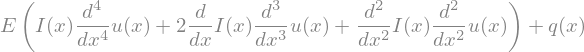

In [26]:
expr = (E * I *u.diff(x,2)).diff(x,2)+q
expr

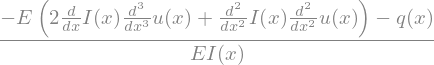

In [29]:
simplify(solve(expr, u.diff(x,4))[0])

$$ \frac{d^2}{dx^2}(EI(x)\frac{d^2u(x)}{dx^2}) = -q(x) $$


$$ \frac{d^4u(x)}{dx^4} = \frac{-1}{I\left(x \right)} \left(2 \frac{dI}{d x} {\left(x \right)} \frac{d^{3}u}{d x^{3}} {\left(x \right)} + \frac{d^{2}I}{d x^{2}} {\left(x \right)} \frac{d^{2}u}{d x^{2}} {\left(x \right)} + \frac {q\left(x \right)}{E}\right)$$

In [11]:
from chords.pseudospectral import _v_sum, piecewise, coll_points
from numpy import array

In [93]:
def bary_poly_num(t_arr, y_arr):
    """
    Generates a numeric function of t that corresponds to the polynomial
    that passes through the points (t, y) using the barycentric formula

    Parameters
    ----------
    t_arr : iterable of floats
        values of t
    y_arr : iterable of floats
        values of y

    Returns
    -------
    polynomial : Function F(t)
        polynomial numerical function

    """
    t = symbols("t")
    n = len(t_arr)
    v_arr = [_v_sum(t_arr, ii) for ii in range(n)]
    sup = 0
    for i in range(n):
        sup += v_arr[i] * y_arr[i] / (t - t_arr[i])
    inf = 0
    for i in range(n):
        inf += v_arr[i] / (t - t_arr[i])
    poly_fun = lambdify(
        [
            t,
        ],
        sup / inf,
    )
    
    def new_poly(t):
        t = array(t, dtype="float64")
        cond_list = [t == t_i for t_i in t_arr]
        func_list = list(y_arr)
        func_list.append(poly_fun)
        return piecewise(t, cond_list, func_list)

    return new_poly

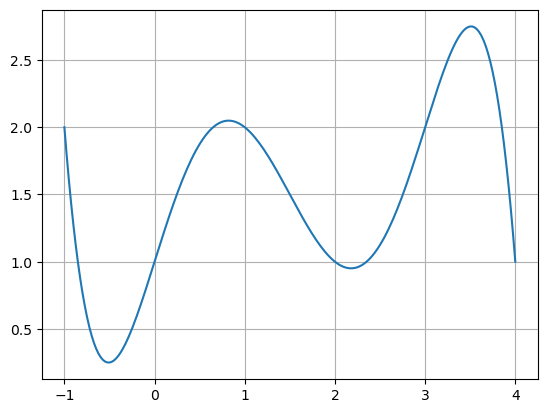

In [94]:
_a = bary_poly_num([-1,0,1,2,3,4], [2,1,2,1,2,1])
_t = np.linspace(-1,4,200)
plt.plot(_t, _a(_t))
plt.grid()

In [95]:
coll_points(5, 'LG')

In [96]:
from sympy import legendre_poly, jacobi_poly, evalf

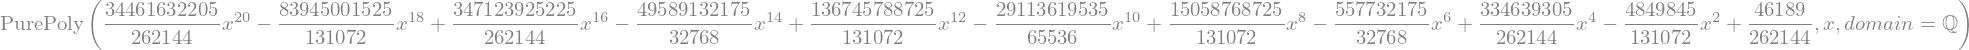

In [97]:
N = 20
_a =legendre_poly(N, polys=True)
_a

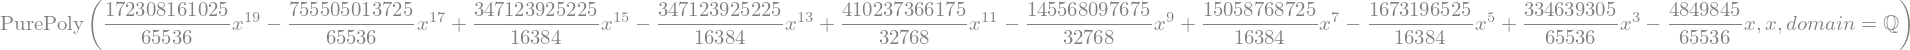

In [76]:
_a.diff()

In [119]:
from functools import lru_cache
from math import ceil

In [89]:
@lru_cache(maxsize=2000)
def LG_weight(N, i, precission = 20):
    Pn = legendre_poly(N, polys=True)
    Pn_d = Pn.diff()
    xi = coll_points(N, 'LG', precission)[i]
    wi = 2/((1-xi**2) * (Pn_d.eval(xi)**2))
    return wi

In [91]:
LG_weight(10,2)

In [106]:
def gauss_integral(f, N, t0, t1):
    scale = t1-t0
    points = (array(coll_points(N, 'LG'))+1)/2
    points = t0 + scale*points
    weights = [LG_weight(N, ii) for ii in range(N)]
    _a = [weights[ii]*f(points[ii]) for ii in range(N)]
    return scale*np.sum(_a)/2

In [120]:
def f_integral(f, N, t0, t1):
    scale = t1-t0
    points = (array(coll_points(N, 'LG'))+1)/2
    points = t0 + scale*points
    points = list(points)
    N_gauss = ceil((N+1)/2)
    y = [gauss_integral(f, N_gauss, t0, ii) for ii in points]
    points = [t0,] + points
    y = [0,] + y
    return bary_poly_num(points, y)

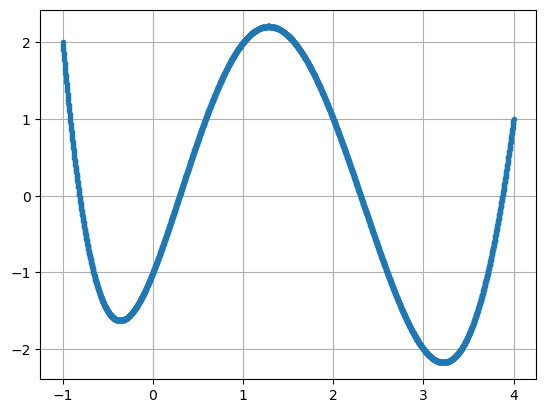

In [130]:
_a = bary_poly_num([-1,0,1,2,3,4], [2,-1,2,1,-2,1])
_t = np.linspace(-1,4,2000)
plt.plot(_t, _a(_t), '.')
plt.grid()

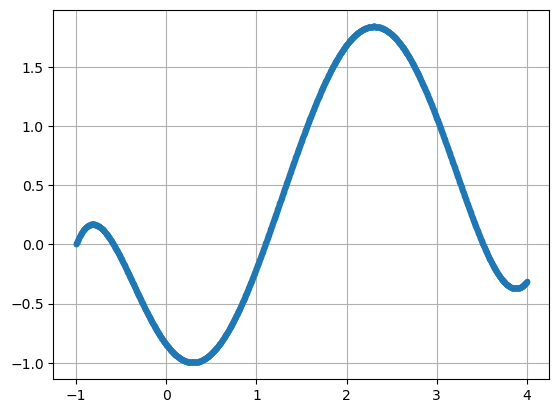

In [131]:
_b = f_integral(_a, 6, -1, 4)
plt.plot(_t, _b(_t), '.')
plt.grid()

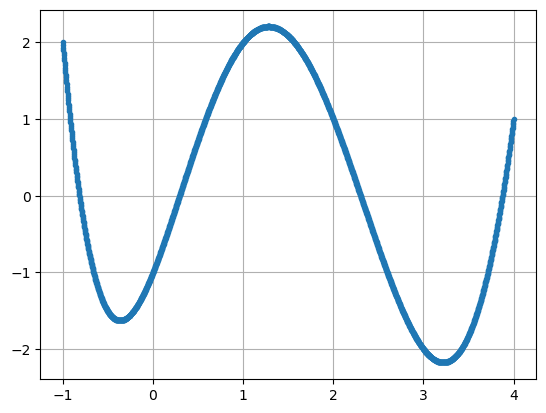

In [132]:
plt.plot(_t, np.gradient(_b(_t), _t, edge_order=2), '.')
plt.grid()

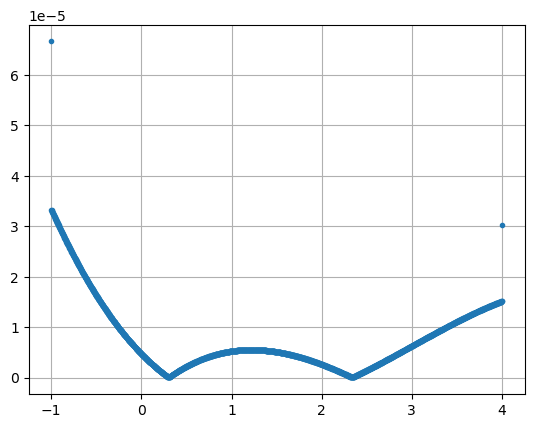

In [133]:
plt.plot(_t, np.abs(np.gradient(_b(_t), _t, edge_order=2)-_a(_t)), '.')
plt.grid()

In [143]:
def deletezeros(expr, tol = 1e-14):
    expr2 = expr
    for a in preorder_traversal(expr):
        if isinstance(a, Float):
            if abs(a) < tol:
                expr2 = expr2.subs(a, 0)
    return expr2

In [150]:
def bary_poly_sym(t_arr, y_arr):
    """
    Generates a symbolic function of t that corresponds to the polynomial
    that passes through the points (t, y) using the barycentric formula

    Parameters
    ----------
    t_arr : iterable of floats
        values of t
    y_arr : iterable of floats
        values of y

    Returns
    -------
    polynomial : Function F(t)
        polynomial numerical function

    """
    t = symbols("t")
    n = len(t_arr)
    v_arr = [_v_sum(t_arr, ii) for ii in range(n)]
    sup = 0
    for i in range(n):
        sup += v_arr[i] * y_arr[i] / (t - t_arr[i])
    inf = 0
    for i in range(n):
        inf += v_arr[i] / (t - t_arr[i])
    poly_fun = sup / inf

    return poly_fun

In [151]:
def poly_sym(t_arr, y_arr):
    """
    Generates a symbolic function of t that corresponds to the polynomial
    that passes through the points (t, y)

    Parameters
    ----------
    t_arr : iterable of floats
        values of t
    y_arr : iterable of floats
        values of y

    Returns
    -------
    polynomial : Function F(t)
        polynomial numerical function

    """
    t = symbols("t")
    n = len(t_arr)
    v_arr = [_v_sum(t_arr, ii) for ii in range(n)]
    sup = 0
    for i in range(n):
        sup += v_arr[i] * y_arr[i] / (t - t_arr[i])
    inf = 0
    for i in range(n):
        inf += v_arr[i] / (t - t_arr[i])
    poly_fun = sup / inf

    return deletezeros(simplify(poly_fun))

In [148]:
_a = bary_poly_sym([-1,0,1,2,3,4], [2,1,-2,1,-2,1])

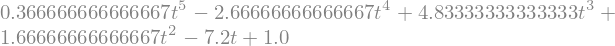

In [149]:
_a

In [13]:
from chords.symbolic import diff_to_symb_expr

In [14]:
x = q1**2 + cos(q2.diff())**3 + sin(q1**2) + acos(q1)
x

In [16]:
from chords.symbolic import print_funcs

In [17]:
print_funcs(x,3)

def F(x, ):
    q_0, q_1, q_2, v_0, v_1, v_2 = unpack(x)
    result = q_1**2 + np.sin(q_1**2) + np.cos(v_2)**3 + np.arccos(q_1)

    return result



'def F(x, ):\n    q_0, q_1, q_2, v_0, v_1, v_2 = unpack(x)\n    result = q_1**2 + np.sin(q_1**2) + np.cos(v_2)**3 + np.arccos(q_1)\n\n    return result\n'

In [5]:
x, a, b, c, d, t, h= symbols('x a b c d t h')
t0, t1, t2, t3, t4 = symbols('t_0 t_1 t_2 t_3 t_4')

In [19]:
sin(pi/2 + a-b)

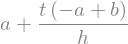

In [20]:
rect = a+ (b-a)/h*t
rect

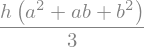

In [21]:
form = integrate(expand(rect**2), (t, 0, h))
form = simplify(form)
factor(form)

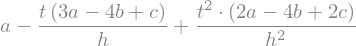

In [22]:
parab = a - t/h* (3*a-4*b+c) + t**2/h**2 * (2*a -4*b +2*c)
parab

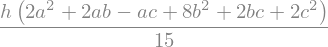

In [23]:
form = integrate(expand(parab**2), (t, 0, h))
form = simplify(form)
factor(form)

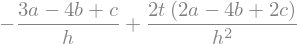

In [24]:
parab.diff(t)

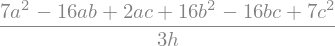

In [25]:
form_2 = integrate(expand(parab.diff(t)**2), (t, 0, h))
form_2 = simplify(form_2)
factor(form_2)

In [6]:
from sympy.printing.numpy import NumPyPrinter

def printer(x):
    np_printer = NumPyPrinter()
    return np_printer.doprint(x)

In [27]:
printer(form)

'(1/15)*h*(2*a**2 + 2*a*b - a*c + 8*b**2 + 2*b*c + 2*c**2)'

In [8]:
polin = a*x**3 + b*x**2 + c*x + d
polin

a*x**3 + b*x**2 + c*x + d

In [ ]:
x_n = [polin.subs(x, ii) for ii in [t0, t1, t2, t3]]
x_n

In [ ]:
pol_dif = polin.diff(x)
pol_dif

In [8]:
def x_roots(n):
    return roots_jacobi(n+1, 1, 0)[0]
def element(x, xm, xj):
    return (x-xm)/(xj-xm)

def L_pol(j,k):
    prod = 1
    #x_list = symbols(f'x_0:{k+1}')
    x_list = x_roots(k)
    for m in range(k+1):
        if m != j:
            prod *= element(x, x_list[m], x_list[j])
    return expand(prod) 

def L_pol_sym(j,k):
    prod = 1
    x_list = symbols(f'x_0:{k+1}')
    #x_list = x_roots(k)
    for m in range(k+1):
        if m != j:
            prod *= element(x, x_list[m], x_list[j])
    return expand(prod) 

def lagpol(n):
    sumat = 0
    q_list = symbols(f'f_0:{n+2}')
    for ii in range(n+1):
        sumat += L_pol(ii, n)*q_list[ii]
    return sumat

def lagpol_sym(n):
    sumat = 0
    q_list = symbols(f'f_0:{n+2}')
    for ii in range(n+1):
        sumat += L_pol_sym(ii, n)*q_list[ii]
    return sumat

def abcpol(n):
    abc = symbols(f'a b c d e f g h i j k l m n o p q r s t u v w a_0:{max(0,n-22)}')
    sumat = 0
    for ii in range(n+1):
        sumat += abc[ii]*x**ii
    return sumat

def lagpol_abc(n):
    sumat = 0
    x_list = x_roots(n)
    abc = abcpol(2*n-1)
    q_list = [abc.subs(x, x_list[ii]) for ii in range(n+1)]
    for ii in range(n+1):
        sumat += L_pol(ii, n)*q_list[ii]
    return sumat

In [9]:
psi_accel_hs = lagpol_sym(2).subs([
    [symbols('x_0'), 0],
    [symbols('x_1'), h*Rational(1,2)],
    [symbols('x_2'), h]    
]).expand().collect(h).collect(x)
psi_accel_hs

f_0 + x*(-3*f_0 + 4*f_1 - f_2)/h + x**2*(2*f_0 - 4*f_1 + 2*f_2)/h**2

In [10]:
exp = integrate(psi_accel_hs, (x, 0, t))+symbols('q^{(M-1)}_0')
exp

f_0*t + q^{(M-1)}_0 + t**2*(-3*f_0 + 4*f_1 - f_2)/(2*h) + t**3*(2*f_0 - 4*f_1 + 2*f_2)/(3*h**2)

In [11]:
exp = integrate(exp, (t, 0, t))+symbols('q^{(M-4)}_0')
exp

f_0*t**2/2 + q^{(M-1)}_0*t + q^{(M-4)}_0 + t**3*(-3*f_0 + 4*f_1 - f_2)/(6*h) + t**4*(f_0 - 2*f_1 + f_2)/(6*h**2)

In [12]:
from math import factorial

In [13]:
psi_accel_tz = lagpol_sym(1).subs([
    [symbols('x_0'), 0],
    [symbols('x_1'), h]    
]).expand().collect(h).collect(x)
psi_accel_tz

f_0 + x*(-f_0 + f_1)/h

In [14]:
exp = integrate(psi_accel_tz, (x, 0, t))+symbols('q^{(M-1)}_0')
exp

f_0*t + q^{(M-1)}_0 + t**2*(-f_0 + f_1)/(2*h)

In [15]:
exp = integrate(exp, (t, 0, t))+symbols('q^{(M-2)}_0')
exp

f_0*t**2/2 + q^{(M-1)}_0*t + q^{(M-2)}_0 + t**3*(-f_0 + f_1)/(6*h)

In [129]:
from chords.piecewise import fac, is2d, vec_len
from copy import copy
from numpy import (
    zeros,
    append,
    concatenate,
    linspace,
    expand_dims,
    interp,
    array,
    sum,
    abs,
)

def get_x_divisions(x, order=2):
    dim = vec_len(x) // order
    x_list = []
    if is2d(x):
        for ii in range(order):
            index = (slice(None, None), slice(dim * ii, dim * (ii + 1)))
            print(index)
            x_list.append(x[index])
    else:
        for ii in range(order):
            index = slice(dim * ii, dim * (ii + 1))
            x_list.append(x[index])
    return x_list

def generate_hs_m_funcs(order):
    M = order  # in order to keep the paper naming
    q_coefs = zeros(order)
    for i in range(order):
        q_coefs[i] = 1 / fac(i)
    q_coefs_c = zeros(order - 1)
    for i in range(order - 1):
        q_coefs_c[i] = 1 / (2**i * fac(i))
    g_coefs = zeros(order + 1)
    g_coefs_c = zeros([order + 1, 5])
    for l in range(1, order + 1):
        g_coefs[l] = fac(l + 2)
        g_coefs_c[l, 0] = 2**l * fac(l) * (l + 2)
        g_coefs_c[l, 1] = 2 * l**2 + 4 * l - 3
        g_coefs_c[l, 2] = 2 ** (l + 1) * fac(l + 2)
        g_coefs_c[l, 3] = 2 * l**2 + 2 * l - 1
        g_coefs_c[l, 4] = -2 * l - 1

    def hs_m_half_x(x, x_n, a, a_n, dt):
        x_c = copy(x)
        x_list = get_x_divisions(x, order)
        x_n_list = get_x_divisions(x_n, order)
        x_c_list = get_x_divisions(x_c, order)
        v = x_list[-1]  # V represents here the highest q derivative contained in x
        v_n = x_n_list[-1]
        for l in range(1, M + 1):
            print( x_c_list[M - l])
            print(
                dt ** (l - 1) / g_coefs_c[l, 0] * (3 * v_n + g_coefs_c[l, 1] * v)
            )
            x_c_list[M - l][:,:] = (
                dt ** (l - 1) / g_coefs_c[l, 0] * (3 * v_n + g_coefs_c[l, 1] * v)
            )
            x_c_list[M - l][:,:] = x_c_list[M - l] + dt**l / g_coefs_c[l, 2] * (
                g_coefs_c[l, 3] * a + g_coefs_c[l, 4] * a_n
            )
            for i in range(l - 1):
                x_c_list[M - l][:,:] = (
                    x_c_list[M - l] + dt**i * q_coefs_c[i] * x_list[i + M - l]
                )
        return x_c, x_c_list

    def hs_m_accel_restr(x, x_n, a, a_n, dt, scheme_params):
        a_c = scheme_params.T
        res = copy(x)
        x_list = get_x_divisions(x, order)
        res_list = get_x_divisions(res, order)
        for l in range(1, M + 1):
            res_list[M - l][:,:] = (
                dt**l / g_coefs[l] * (l**2 * a + 4 * l * a_c + (2 - l) * a_n)
            )
            print(f'res:{res} res_list:{res_list}')
            for i in range(l):
                res_list[M - l][:,:] = (
                    res_list[M - l] + dt**i * q_coefs[i] * x_list[i + M - l]
                )
        return x_n - res

    return hs_m_half_x, hs_m_accel_restr

In [130]:
_xc, _rest = generate_hs_m_funcs(3)

In [131]:
q_0, q_1, q_c,v_0, v_1, v_c, a_0, a_1, a_c, g_0, g_1, g_c = symbols(
    'q_k q_{k+1} q_c v_k v_{k+1} v_c a_k a_{k+1} a_c g_k g_{k+1} g_c '
)
q_0, q_1, q_c,v_0, v_1, v_c, a_0, a_1, a_c, g_0, g_1, g_c

In [132]:
x_0 = Matrix([[q_0, v_0, a_0]])
x_1 = Matrix([[q_1, v_1, a_1]])
x_c = Matrix([[q_c, v_c, a_c]])

In [133]:
_xc(x_0, x_1, Matrix([[g_0]]), Matrix([[g_1]]), h)

(slice(None, None, None), slice(0, 1, None))
(slice(None, None, None), slice(1, 2, None))
(slice(None, None, None), slice(2, 3, None))
(slice(None, None, None), slice(0, 1, None))
(slice(None, None, None), slice(1, 2, None))
(slice(None, None, None), slice(2, 3, None))
(slice(None, None, None), slice(0, 1, None))
(slice(None, None, None), slice(1, 2, None))
(slice(None, None, None), slice(2, 3, None))
Matrix([[a_k]])
Matrix([[0.5*a_k + 0.5*a_{k+1}]])
Matrix([[v_k]])
Matrix([[0.03125*h*(13.0*a_k + 3*a_{k+1})]])
Matrix([[q_k]])
Matrix([[0.00416666666666667*h**2*(27.0*a_k + 3*a_{k+1})]])


In [134]:
print(x_0[:])

[q_k, v_k, a_k]


In [135]:
_rest(x_0, x_1, Matrix([[g_0]]), Matrix([[g_1]]), h, Matrix([[g_c]]))

(slice(None, None, None), slice(0, 1, None))
(slice(None, None, None), slice(1, 2, None))
(slice(None, None, None), slice(2, 3, None))
(slice(None, None, None), slice(0, 1, None))
(slice(None, None, None), slice(1, 2, None))
(slice(None, None, None), slice(2, 3, None))
res:Matrix([[q_k, v_k, a_k]]) res_list:[Matrix([[q_k]]), Matrix([[v_k]]), Matrix([[0.166666666666667*h*(4*g_c + g_k + g_{k+1})]])]
res:Matrix([[q_k, v_k, a_k]]) res_list:[Matrix([[q_k]]), Matrix([[0.0416666666666667*h**2*(8*g_c + 4*g_k)]]), Matrix([[a_k + 0.166666666666667*h*(4*g_c + g_k + g_{k+1})]])]
res:Matrix([[q_k, v_k, a_k]]) res_list:[Matrix([[0.00833333333333333*h**3*(12*g_c + 9*g_k - g_{k+1})]]), Matrix([[1.0*a_k*h + 0.0416666666666667*h**2*(8*g_c + 4*g_k) + v_k]]), Matrix([[a_k + 0.166666666666667*h*(4*g_c + g_k + g_{k+1})]])]


In [107]:
x_0

In [144]:
_z = x_0[(slice(None, None, None), slice(1, 2, None))]

In [146]:
_z[:,:] = Matrix([[3]])

In [147]:
x_0

In [148]:
_z

In [113]:
_z = get_x_divisions(x_0,3)

In [117]:
_z[0][:,:] = Matrix([[3]])

In [118]:
_z

In [119]:
x_0

In [121]:
is2d(x_0)

True